In [2]:
import multicam_calibration as mcc
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import flammkuchen as fl
%matplotlib widget

In [3]:
data_folder = Path("/Users/vigji/Downloads/thomas_data")
detection_files = list(data_folder.glob("*.h5"))

all_data = [fl.load(file) for file in detection_files]
labels = [file.stem.split(".aviencoded")[0].split("_")[-1] for file in detection_files]

In [9]:
# uvs = np.stack([data["uvs"] for data in all_data])
n_pts = max([data["frame_ixs"].max() for data in all_data]) + 1
all_calib_uvs = np.full((len(all_data), n_pts, 35, 2), np.nan)
for data in all_data:
    all_calib_uvs[:, data["frame_ixs"], :, :] = data["uvs"]

all_img_sizes = [data["img_size"] for data in all_data]

In [7]:
loaded_data =fl.load("/Users/vigji/Downloads/args_calibration.h5")

In [12]:
all_calib_uvs = loaded_data["all_calib_uvs"]
all_img_sizes = loaded_data["all_img_sizes"]

In [13]:
board_shape = (5,7)
square_size = 12.5

calib_objpoints = mcc.generate_chessboard_objpoints(board_shape, square_size)
s = slice(None, None)

all_extrinsics, all_intrinsics, calib_poses, spanning_tree = mcc.calibrate(
    all_calib_uvs[:, s, :, :], all_img_sizes, calib_objpoints, root=0, n_samples_for_intrinsics=100)
# fig.savefig(data_dir / "shared_detections.png")

Estimating camera intrinsics


100%|█████████████████████████████████████| 5/5 [00:17<00:00,  3.47s/it]


Initializing calibration object poses


100%|█████████████████████████████████████| 5/5 [00:01<00:00,  3.53it/s]

Estimating camera extrinsics
Merging calibration object poses


In [17]:
np.sum(~np.isnan(all_calib_uvs[:, :, 0, 0]), axis=1)

array([3900, 1269, 1728,  735, 1668])

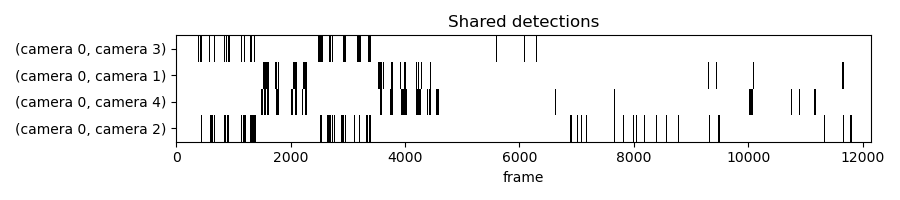

In [14]:
fig, shared_detections = mcc.plot_shared_detections(all_calib_uvs, spanning_tree)

In [18]:
import tqdm
import cv2
n_cameras, n_frames, N, _ = all_calib_uvs.shape
median_error = np.zeros(n_cameras)
reprojections = np.zeros((n_cameras, n_frames, N, 2))
transformed_reprojections = np.zeros((n_cameras, n_frames, N, 2)) * np.nan
pts = mcc.embed_calib_objpoints(calib_objpoints, calib_poses)

errors_list = []
for cam in tqdm.trange(n_cameras):
    reprojections[cam] = mcc.project_points(
        pts, all_extrinsics[cam], all_intrinsics[cam][0]
    )
    uvs_undistorted = mcc.undistort_points(all_calib_uvs[cam], *all_intrinsics[cam])
    valid_ixs = np.nonzero(~np.isnan(uvs_undistorted).any((-1, -2)))[0]
    for t in valid_ixs:
        H = cv2.findHomography(uvs_undistorted[t], calib_objpoints[:, :2])
        transformed_reprojections[cam, t] = cv2.perspectiveTransform(
            reprojections[cam, t][np.newaxis], H[0]
        )[0]

    errors = np.linalg.norm(
        transformed_reprojections[cam, valid_ixs] - calib_objpoints[:, :2],
        axis=-1,
    )
    median_error[cam] = np.median(errors)
    errors_arr = np.zeros(n_frames)*np.nan
    errors_arr[valid_ixs] = np.median(errors, axis=1)
    errors_list.append(errors_arr)

100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


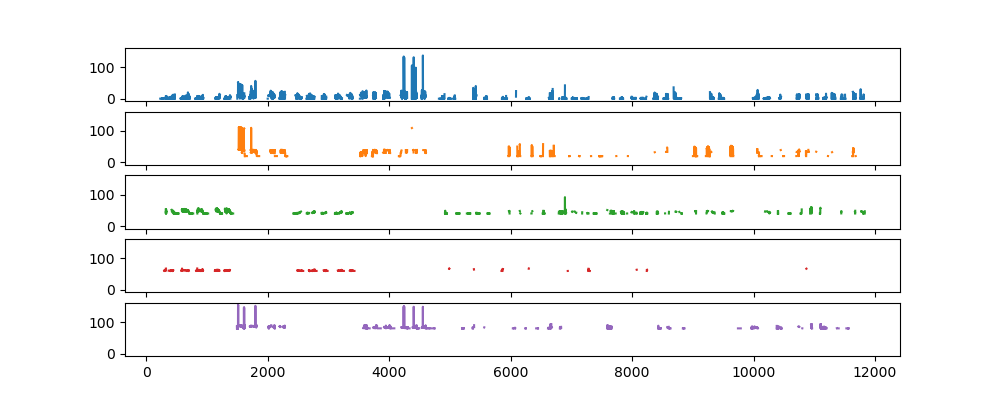

In [19]:
f, axs = plt.subplots(len(errors_list), 1, figsize=(10, 4), sharex=True, sharey=True)

for i, errors in enumerate(errors_list):
    axs[i].plot(errors + i*20, c=f"C{i}")
# plt.plot(errors_list[0].mean(1))

100%|██████████| 5/5 [00:01<00:00,  4.82it/s]


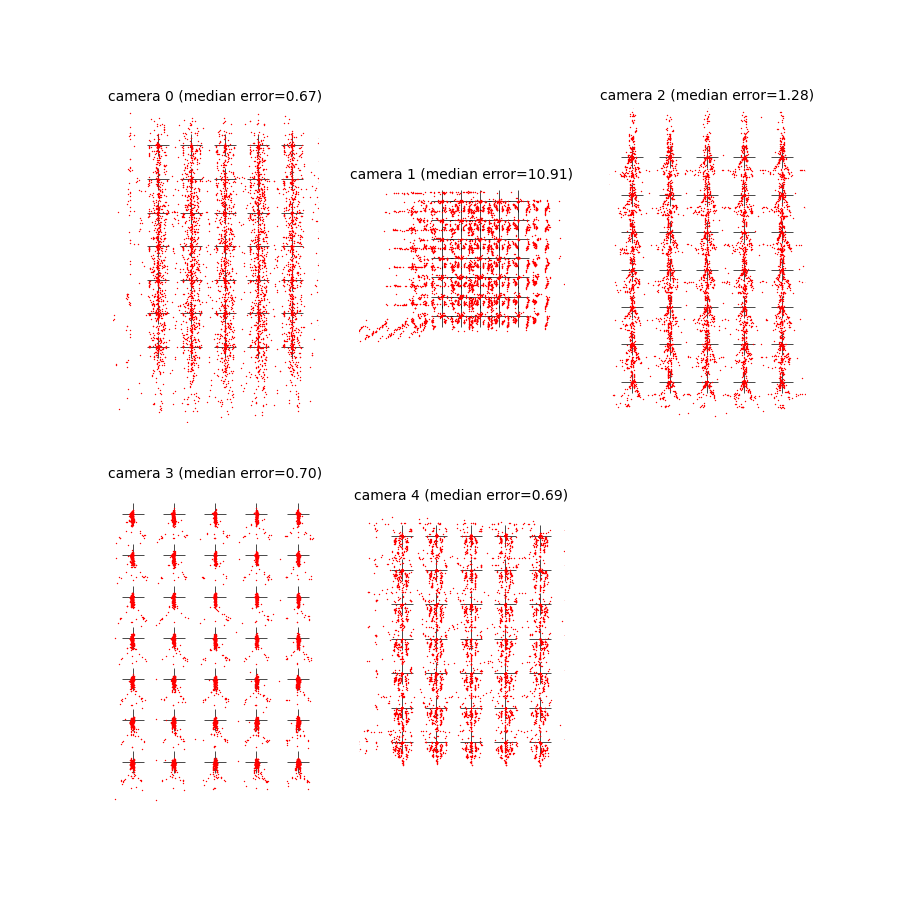

In [22]:
s = slice(0, None)
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:, s, :, :], all_extrinsics, all_intrinsics, calib_objpoints, calib_poses[s, :], 
    # cam_names=camera_names,
    inches_per_axis=3)
# fig.savefig(data_dir / "first_residuals.png")

In [23]:
adj_extrinsics, adj_intrinsics, adj_calib_poses, use_frames, result = \
    mcc.bundle_adjust(all_calib_uvs, all_extrinsics, all_intrinsics, calib_objpoints, calib_poses, n_frames=None, ftol=1e-4)

Excluding 150 out of 2206 frames based on an outlier threshold of 27.45376770132726
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3344e+06                                    8.53e+07    
       1              8         9.8610e+05      3.48e+05       6.42e+01       8.48e+07    
       2              9         7.4305e+05      2.43e+05       2.00e+02       8.19e+07    
       3             10         5.3658e+05      2.06e+05       1.50e+02       5.20e+07    
       4             11         4.7914e+05      5.74e+04       1.78e+02       4.61e+07    
       5             12         4.3220e+05      4.69e+04       2.10e+02       3.51e+07    
       6             13         4.0989e+05      2.23e+04       2.18e+02       3.00e+07    
       7             14         3.7973e+05      3.02e+04       5.65e+01       2.86e+07    
       8             15         3.6084e+05      1.89e+04       1.12e+02       2.56e+07    
      

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 10.46it/s]


NameError: name 'data_dir' is not defined

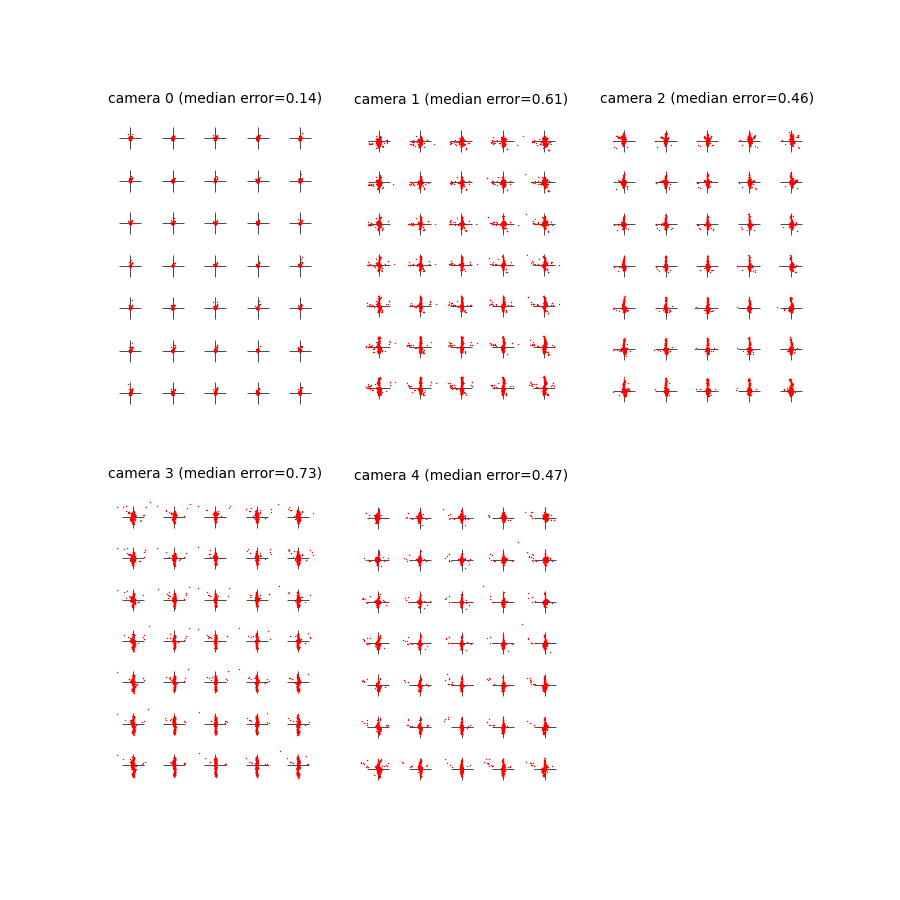

In [24]:
fig, median_error, reprojections, transformed_reprojections = mcc.plot_residuals(
    all_calib_uvs[:,use_frames], adj_extrinsics, adj_intrinsics, calib_objpoints, adj_calib_poses, inches_per_axis=3)
fig.savefig(data_dir / "refined_residuals.png")

## Triangulation

In [25]:
all_triang = []
for i in tqdm.tqdm(range(35)):
    all_triang.append(mcc.triangulate(all_calib_uvs[:, :, i, :], all_extrinsics, all_intrinsics))
all_triang = np.array(all_triang)

100%|██████████| 35/35 [00:11<00:00,  3.11it/s]


array([  297,   298,   300, ..., 11815, 11816, 11830])

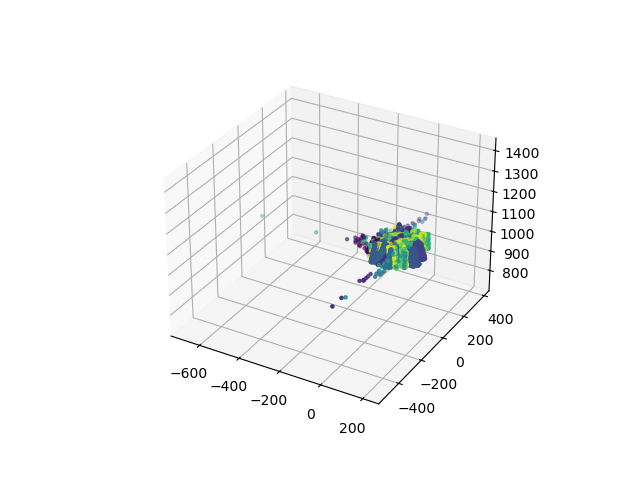

In [66]:
# Make a 3D scatterplot with triangulation for the first frame
# for frame_n in [10, 200, 300, 400]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
    
frame = np.argwhere(np.isnan(all_triang).sum((0, 2)) == 0)[:, 0][frame_n]
# ax.scatter(all_triang[:, frame, 0], all_triang[:, frame, 1], all_triang[:, frame, 2])
dwn = 10
ax.scatter(all_triang[:, :, 0].T.flatten()[::dwn], all_triang[:, :, 1].T.flatten()[::dwn], all_triang[:, :, 2].T.flatten()[::dwn],
           c=np.arange(len(all_triang[:, :, 0].T.flatten()[::dwn])), s=5)
# ax.set_xlim(-50, 50)
# ax.set_ylim(-50, 50)
# ax.set_zlim(-50, 50)
plt.axis('equal')
plt.show()

In [46]:
np.nanmax(all_calib_uvs, (1, 2))

array([[516.22918701, 527.65093994],
       [448.33609009, 127.20126343],
       [468.1895752 , 138.        ],
       [417.52761841, 122.56539917],
       [423.6307373 , 132.68766785]])

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1388.38it/s]


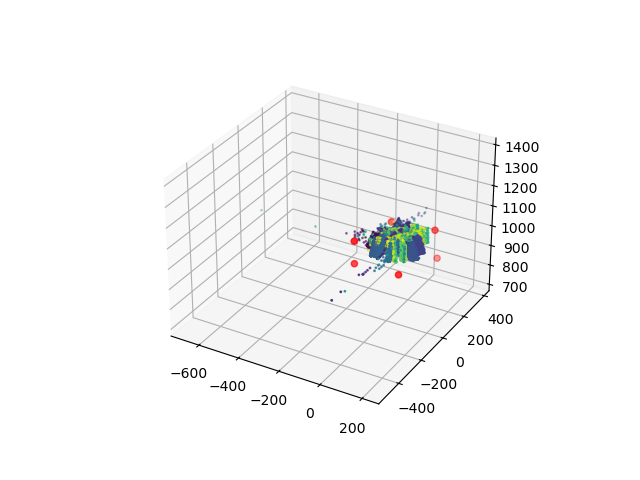

In [72]:
import json
box_points_file = Path("/Users/vigji/Downloads/multicam_video_2024-08-01T11_14_48_20241025-110012.json")
with open(box_points_file, "r") as f:
    box_points = json.load(f)
all_pts = []
for k, vals in box_points[-1]["points_coordinate"].items():
    all_pts.append(np.array(vals))
all_pts = np.array(all_pts)


all_pts = all_pts[:, np.newaxis, :, :]
board_triang = []
for i in tqdm.tqdm(range(8)):
    board_triang.append(mcc.triangulate(all_pts[:, :, i, [1, 0]], all_extrinsics, all_intrinsics))
board_triang = np.array(board_triang)

# Make a 3D scatterplot with triangulation for the first frame
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
    
ax.scatter(all_triang[:, :, 0].T.flatten()[::dwn], all_triang[:, :, 1].T.flatten()[::dwn], all_triang[:, :, 2].T.flatten()[::dwn],
           c=np.arange(len(all_triang[:, :, 0].T.flatten()[::dwn])), s=1)
ax.scatter(board_triang[:, 0, 0], board_triang[:, 0, 1], board_triang[:, 0, 2], s=20, c='r')
ax.axis('equal')
plt.show()


In [56]:
# Try all possible dimension permutations after first dim
import itertools
dims = [1, 2, 3, 4] # dimensions after first one
all_perms = list(itertools.permutations(dims))


[(1, 2, 3, 4),
 (1, 2, 4, 3),
 (1, 3, 2, 4),
 (1, 3, 4, 2),
 (1, 4, 2, 3),
 (1, 4, 3, 2),
 (2, 1, 3, 4),
 (2, 1, 4, 3),
 (2, 3, 1, 4),
 (2, 3, 4, 1),
 (2, 4, 1, 3),
 (2, 4, 3, 1),
 (3, 1, 2, 4),
 (3, 1, 4, 2),
 (3, 2, 1, 4),
 (3, 2, 4, 1),
 (3, 4, 1, 2),
 (3, 4, 2, 1),
 (4, 1, 2, 3),
 (4, 1, 3, 2),
 (4, 2, 1, 3),
 (4, 2, 3, 1),
 (4, 3, 1, 2),
 (4, 3, 2, 1)]

In [ ]:
for perm in all_perms:
    # Permute dimensions
    indexes = [0] + list(perm)
    pts_perm = all_pts[indexes, :, :, :]  # np.transpose(all_pts, (0,) + perm)
    pts_perm = pts_perm[:, :, :, [1, 0]]
    
    # Triangulate with permuted points
    board_triang = []
    for i in tqdm.tqdm(range(8)):
        board_triang.append(mcc.triangulate(pts_perm[:, :, i, :], all_extrinsics, all_intrinsics))
    board_triang = np.array(board_triang)
    
    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(all_triang[:, :, 0].T.flatten()[::dwn], all_triang[:, :, 1].T.flatten()[::dwn], all_triang[:, :, 2].T.flatten()[::dwn],
           c=np.arange(len(all_triang[:, :, 0].T.flatten()[::dwn])), s=1)
    ax.scatter(board_triang[:, 0, 0], board_triang[:, 0, 1], board_triang[:, 0, 2], s=20, c='r')
    plt.title(f'Permutation: {perm}')
    ax.axis('equal')
    plt.show()


In [74]:
# compute distances between all pairs in the 8 points in board_triang:
for i in range(8):
    for j in range(i+1, 8):
        dist = np.linalg.norm(board_triang[i] - board_triang[j])
        print(f'Distance between point {i} and point {j}: {dist}')



Distance between point 0 and point 1: 318.7265659256498
Distance between point 0 and point 2: 458.02083162594676
Distance between point 0 and point 3: 328.8870224531559
Distance between point 0 and point 4: 144.55321521592788
Distance between point 0 and point 5: 357.23182118603756
Distance between point 0 and point 6: 467.64378280381203
Distance between point 0 and point 7: 344.2181169003041
Distance between point 1 and point 2: 329.5372959908237
Distance between point 1 and point 3: 458.10889225814725
Distance between point 1 and point 4: 354.036724261965
Distance between point 1 and point 5: 149.34674935444068
Distance between point 1 and point 6: 353.3306672160833
Distance between point 1 and point 7: 473.32115139652495
Distance between point 2 and point 3: 319.54707168955173
Distance between point 2 and point 4: 479.414509694145
Distance between point 2 and point 5: 353.83311032862133
Distance between point 2 and point 6: 127.65574398572633
Distance between point 2 and point 7: 34

In [55]:
pts_perm.shape

(5, 1, 2, 8)